In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#load dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv('dataset/incident_profile_95_cleaned.csv')
df.columns.sort_values()

Index(['BEAT_OF_OCCURRENCE', 'CRASH_MONTH', 'CRASH_YEAR',
       'adverse_weather_crash_rate', 'avg_age', 'avg_crash_severity_score',
       'avg_lighting_severity', 'avg_responsibility_score',
       'avg_roadway_severity', 'avg_weather_severity',
       'combined_weather_road_severity', 'damage_cost_LB', 'damage_high',
       'damage_low', 'damage_medium', 'fatality_rate', 'injury_severity_score',
       'monthly_total_units', 'neo_patented_drivers', 'night_crash_rate',
       'num_towed_units_LB', 'pct_neo_patented_drivers', 'pct_senior_drivers',
       'road_defect_crash_rate', 'senior_drivers', 'severe_injury_rate',
       'speeding_influence', 'sum_category_motorcycle',
       'sum_category_off-road/specialized', 'sum_category_passenger vehicle',
       'sum_category_public transport', 'sum_category_truck/commercial',
       'sum_damage_category_high', 'sum_damage_category_low',
       'sum_damage_category_medium', 'sum_lighting_category_daylight',
       'sum_lighting_category_n

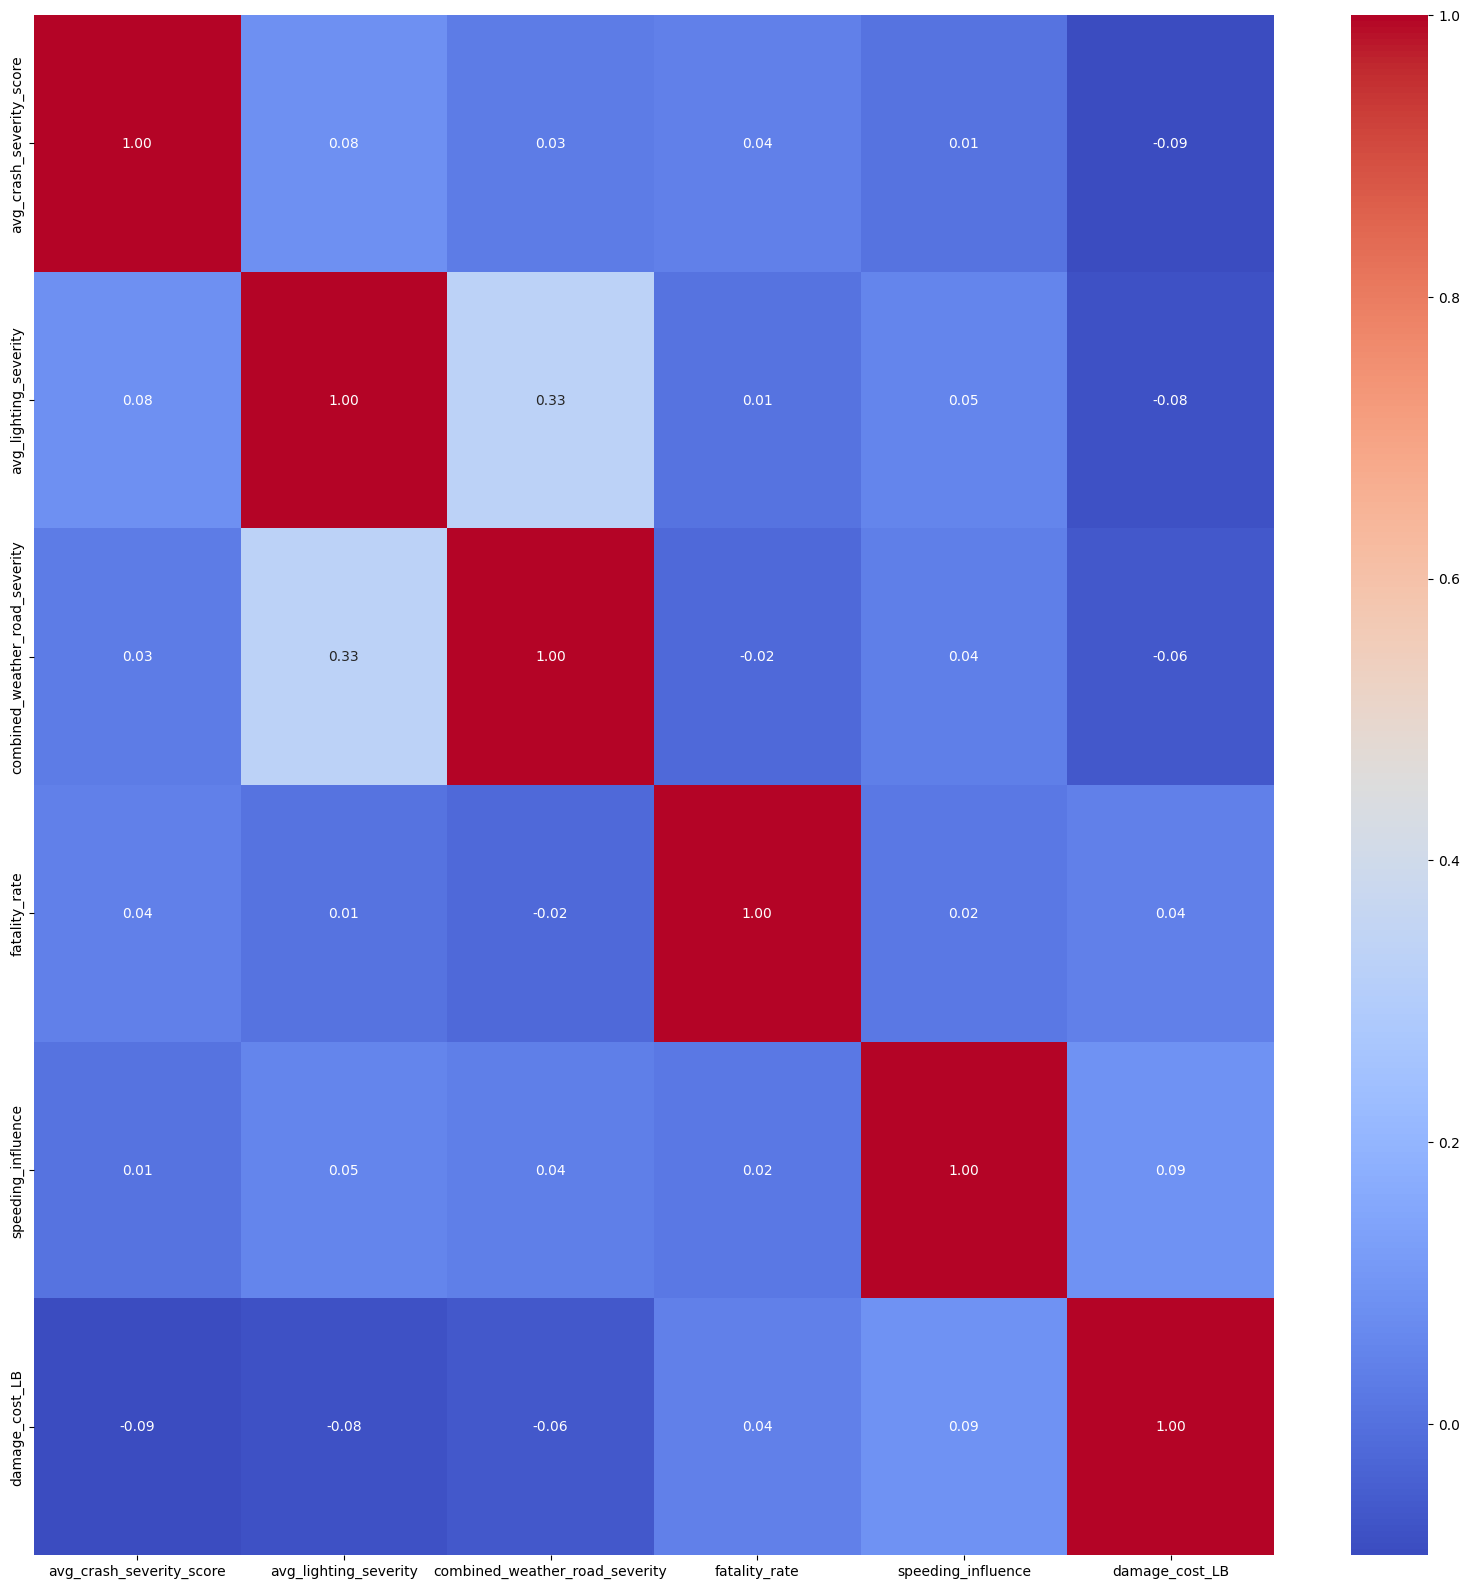

In [11]:
#dbscan
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

selected_features = ['avg_age', 'avg_weather_severity', 'fatality_rate', 'severe_injury_rate', 
                     'damage_cost_LB', 'speeding_influence',
           'weekend_crash_rate','road_defect_crash_rate','night_crash_rate','avg_responsibility_score']

selected_features = ['avg_weather_severity', 'severe_injury_rate', "avg_crash_severity_score",
                     'damage_cost_LB', 'speeding_influence',
           'weekend_crash_rate','road_defect_crash_rate','night_crash_rate','avg_responsibility_score']

selected_features = ['avg_weather_severity', 'severe_injury_rate', "avg_crash_severity_score",
                     'damage_cost_LB',
           'weekend_crash_rate','road_defect_crash_rate','night_crash_rate']

selected_features = ['avg_crash_severity_score', 'avg_lighting_severity', 'combined_weather_road_severity', 'fatality_rate', 'speeding_influence', 'damage_cost_LB']
plt.figure(figsize=(20, 20))
sns.heatmap(df[selected_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [12]:
scaler_ss = StandardScaler()
df_cluster_ss = scaler_ss.fit_transform(df[selected_features])
df_cluster_ss = pd.DataFrame(df_cluster_ss, columns=df[selected_features].columns)
df_cluster_ss.head()

,avg_crash_severity_score,avg_lighting_severity,combined_weather_road_severity,fatality_rate,speeding_influence,damage_cost_LB
0,-0.594719,0.440448,0.528371,-0.169046,0.421623,0.775171
1,0.702175,-0.714096,-0.628140,-0.169046,0.178818,-0.255078
2,-1.384838,0.246690,0.039103,-0.169046,0.237913,-0.934107
3,0.021122,0.232783,0.726945,-0.169046,2.777173,3.748847
4,-0.388483,-0.290854,0.737382,-0.169046,-0.599440,1.126393


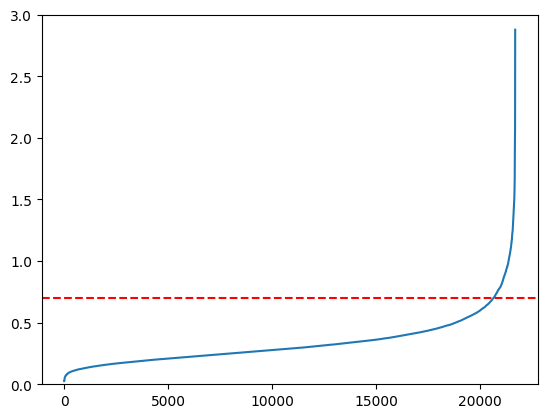

In [13]:
#find the best eps
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=20)
nbrs = neigh.fit(df_cluster_ss)
distances, indices = nbrs.kneighbors(df_cluster_ss)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
#create a line on the elbow
plt.axhline(y=0.7, color='r', linestyle='--')
plt.ylim(0, 3)
plt.show()

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
from tqdm import tqdm

best_score = -1
best_min_samples = None
best_eps = None

# Define a range of values for min_samples
min_samples_range = range(5, 15)

# Define a range of values for eps (you can use the k-distance graph to narrow this range)
eps_range = np.arange(0.4, 0.9, 0.05)

scores = []

for min_samples in tqdm(min_samples_range, desc="min_samples"):
    for eps in tqdm(eps_range, desc="eps", leave=False):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_cluster_ss)
        
        # Ignore cases where all points are labeled as noise
        if len(set(labels)) > 1:
            score = silhouette_score(df_cluster_ss, labels)
            scores.append((score, min_samples, eps))
        
# Sort scores in descending order
scores.sort(reverse=True, key=lambda x: x[0])

#put scores in a csv
scores_df = pd.DataFrame(scores, columns=['score', 'min_samples', 'eps'])
scores_df.to_csv('dbscan_scores.csv', index=False)


min_samples: 100%|██████████| 10/10 [15:32<00:00, 93.24s/it]


In [15]:
scores_df.head(10)

,score,min_samples,eps
0,0.391789,14,0.80
1,0.379113,14,0.85
2,0.378598,13,0.85
3,0.378365,11,0.75
4,0.377557,10,0.80
5,0.374587,11,0.80
6,0.373122,12,0.75
7,0.370800,13,0.80
8,0.368562,13,0.75
9,0.363341,10,0.75


In [21]:
dbscan = DBSCAN(eps=0.85, min_samples=14)
labels = dbscan.fit_predict(df_cluster_ss)
df['cluster'] = labels
df['cluster'].value_counts()

cluster
 0    19971
-1     1679
 1       40
Name: count, dtype: int64

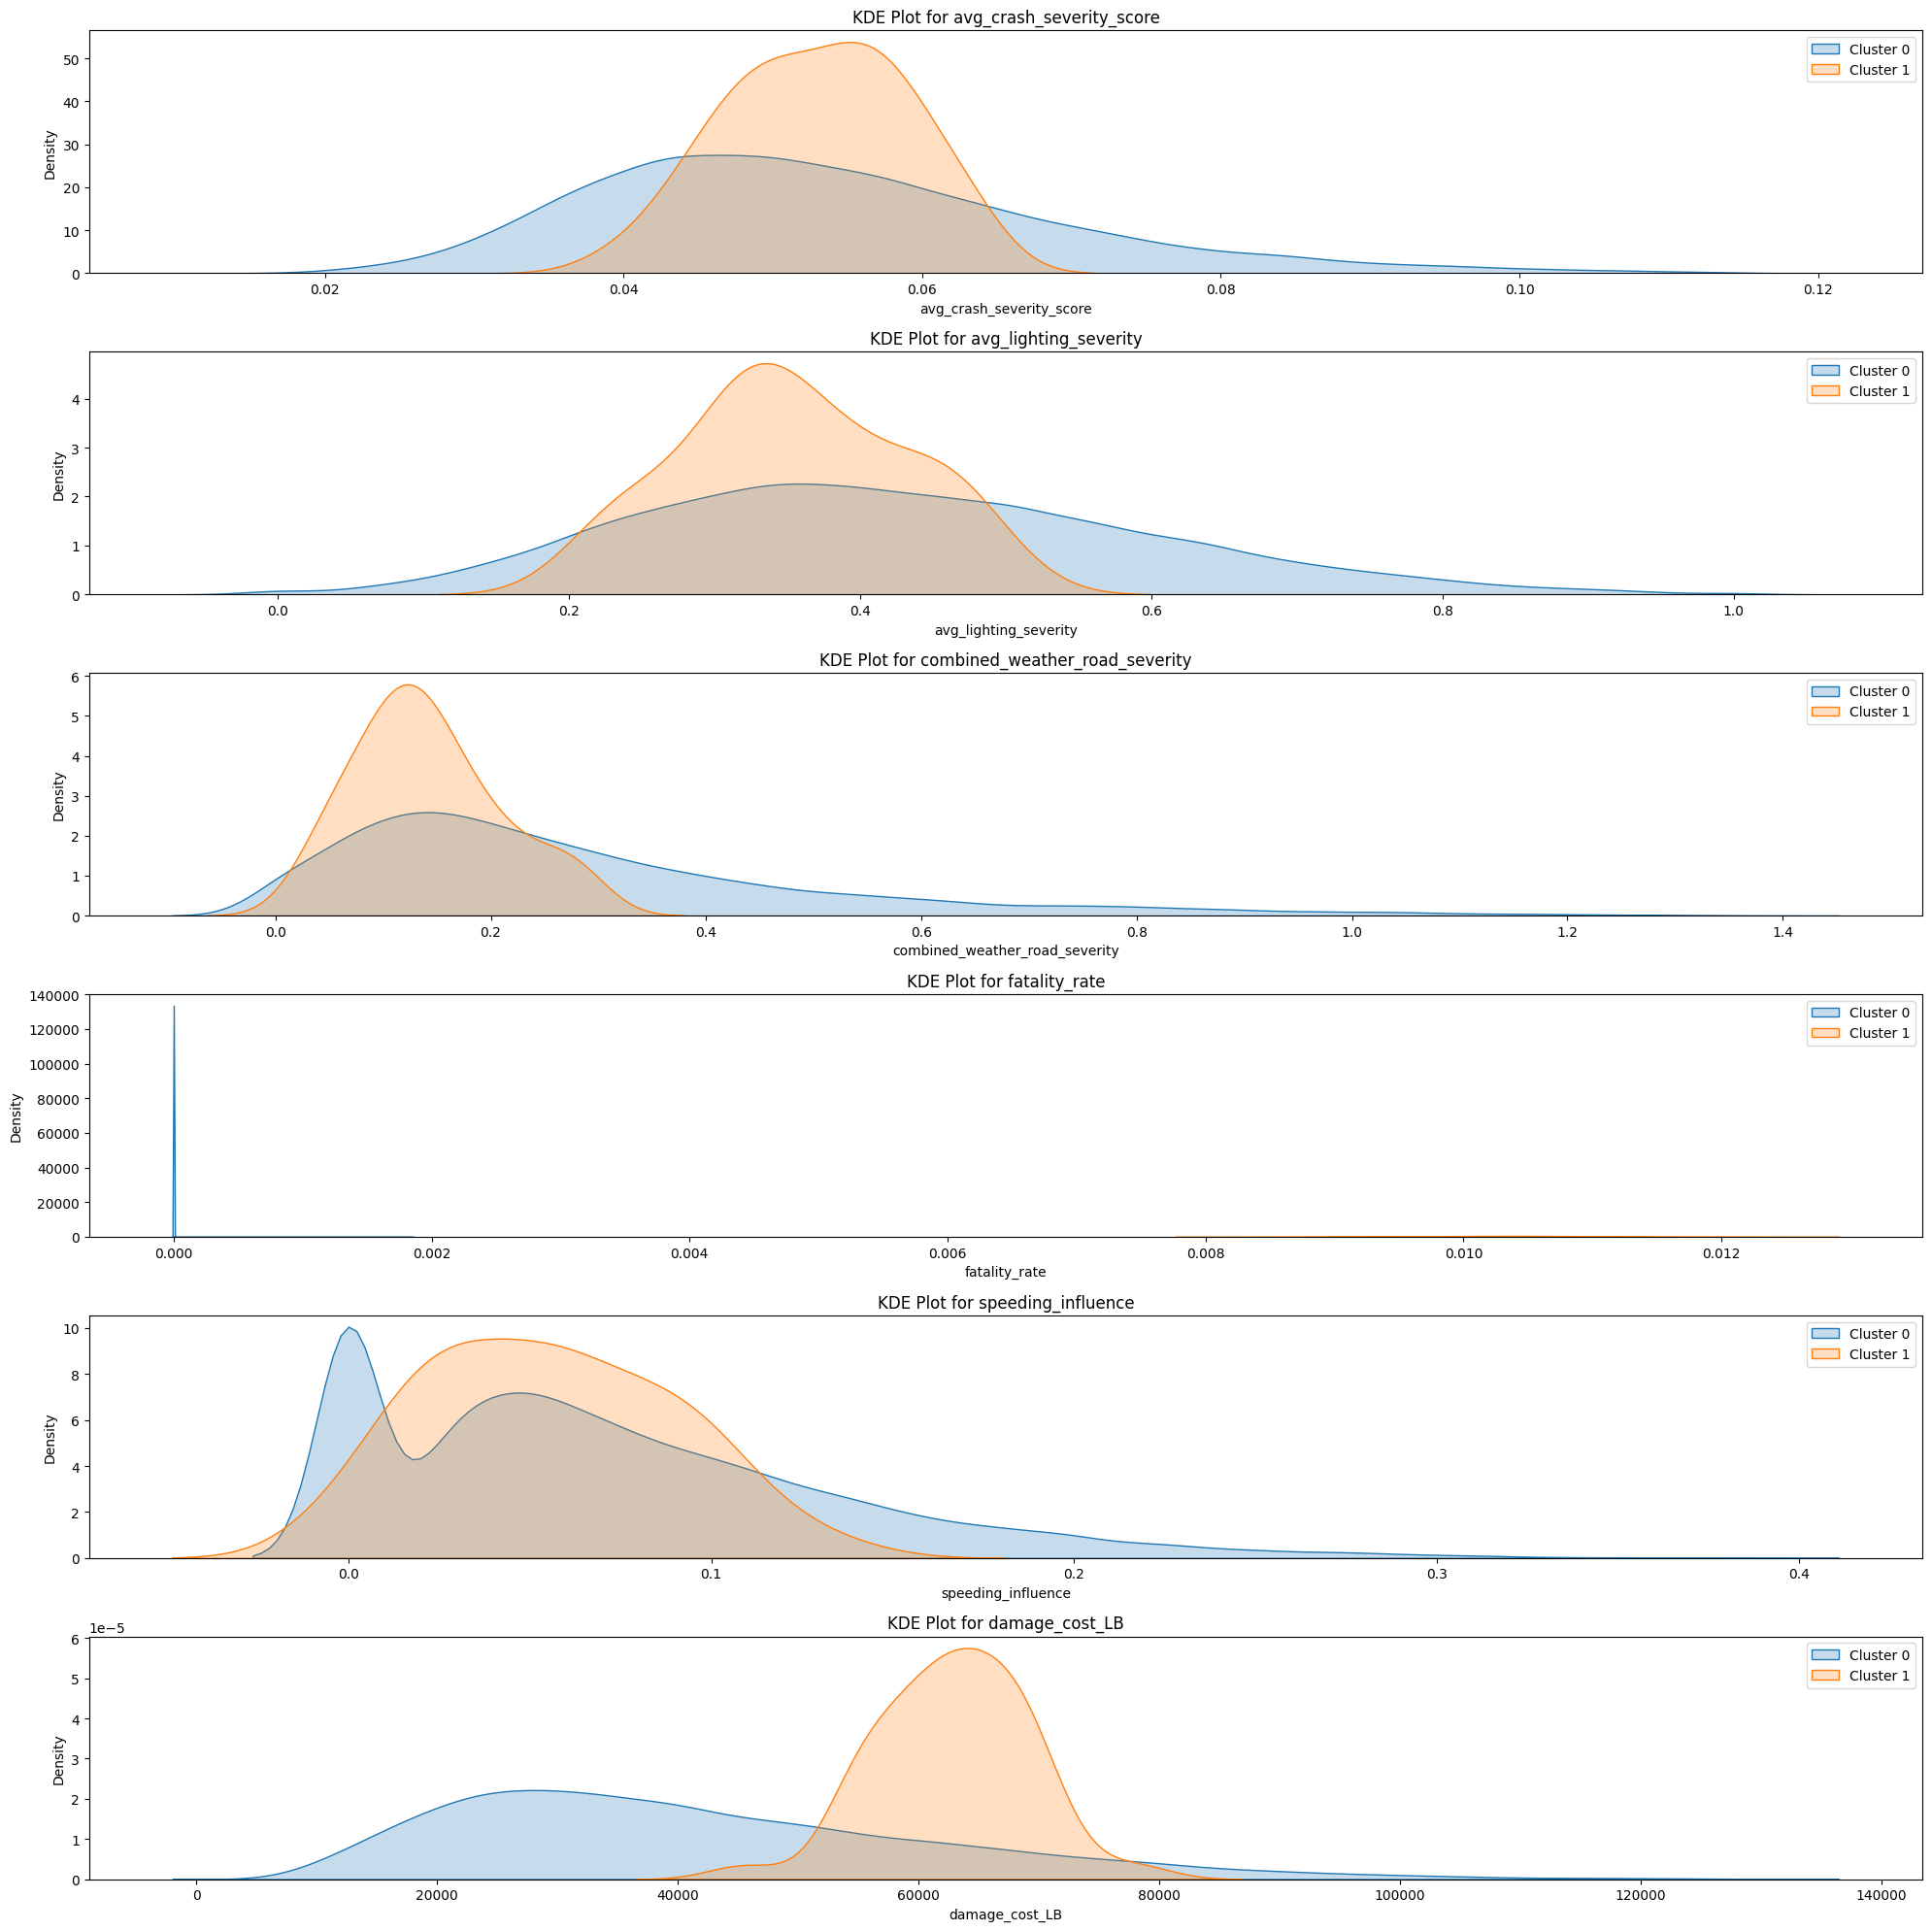

In [26]:
features = selected_features

plt.figure(figsize=(20, 20))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    for cluster in range(len(df['cluster'].unique())):
        sns.kdeplot(df[df['cluster'] == cluster][feature], label=f'Cluster {cluster}', fill=True)
    plt.title(f'KDE Plot for {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

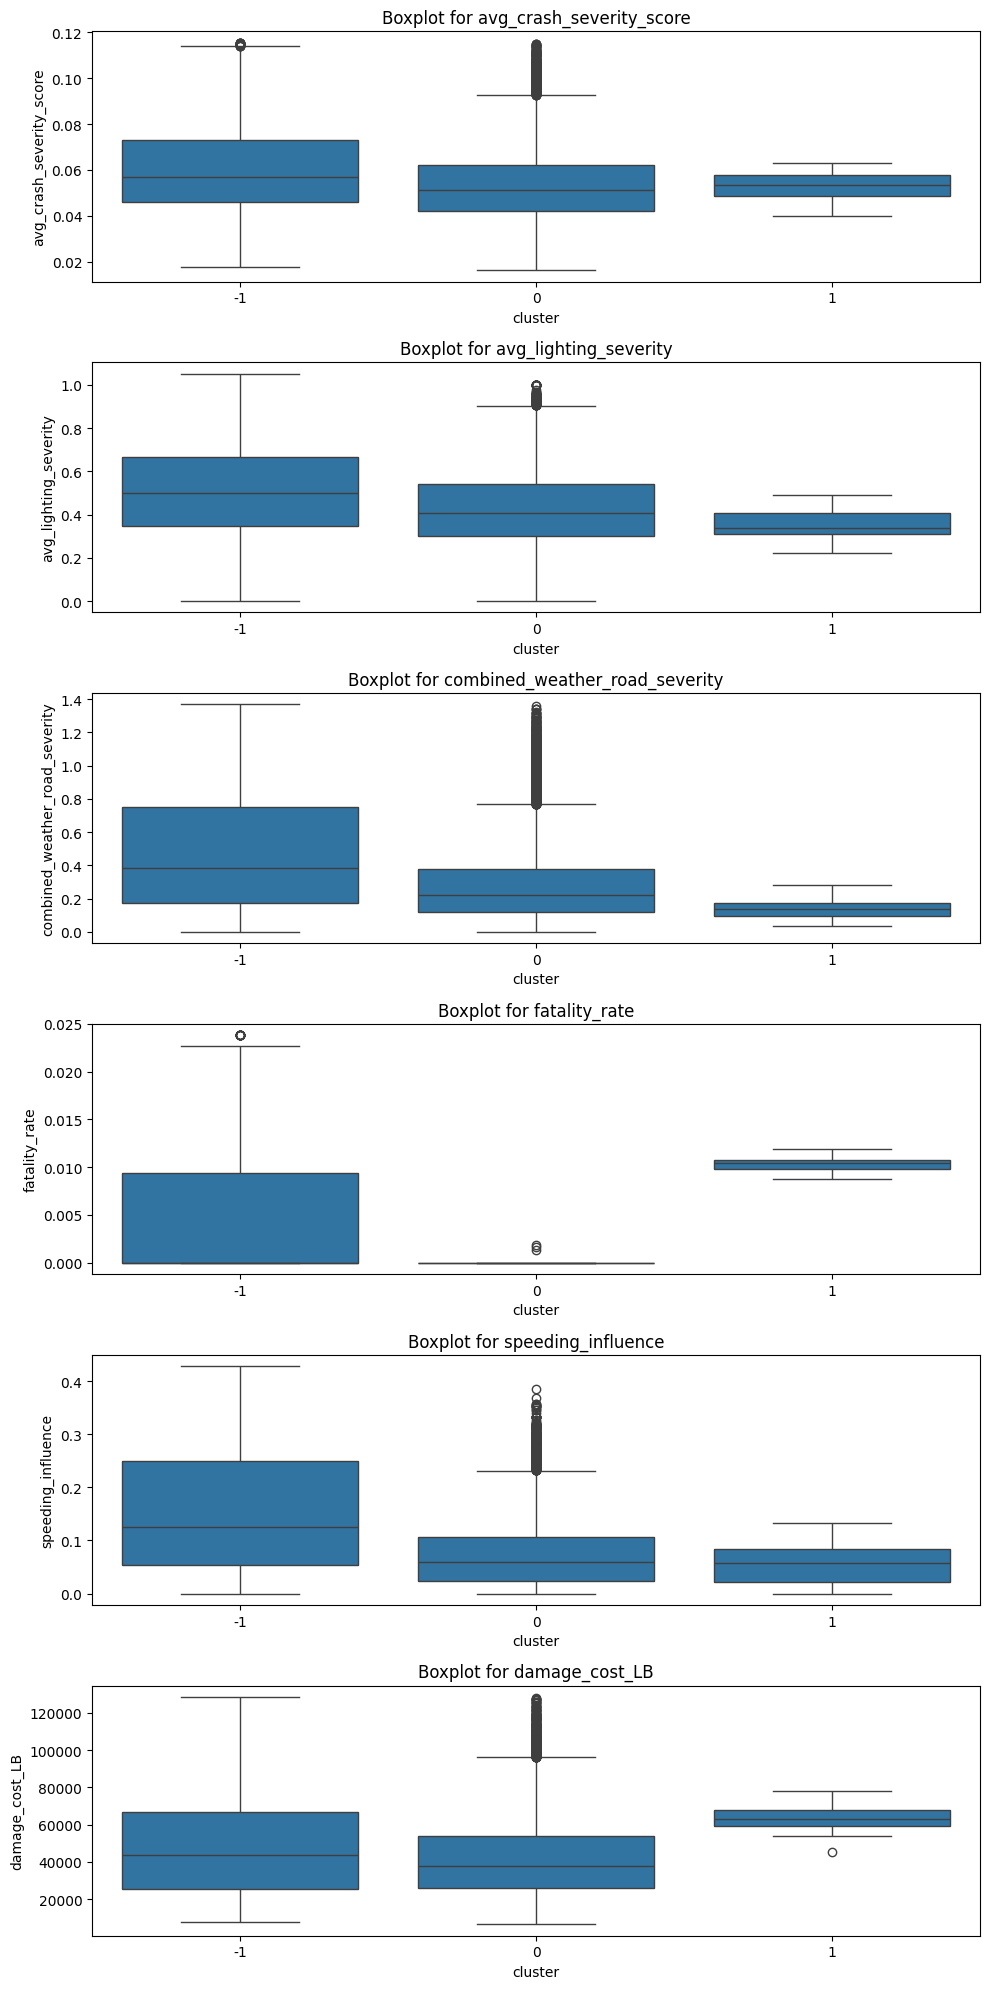

In [27]:
features = selected_features

plt.figure(figsize=(10, 20))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    sns.boxplot(x='cluster', y=feature, data=df)
    plt.title(f'Boxplot for {feature}')
plt.tight_layout()
plt.show()


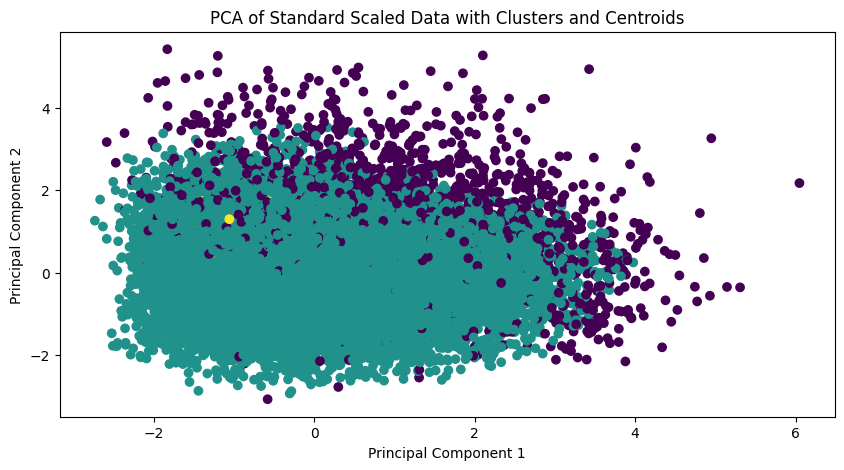

In [30]:
#pca with clusters
pca = PCA(n_components=2)
df_cluster_pca_ss = pca.fit_transform(df_cluster_ss)

plt.figure(figsize=(10, 5))
plt.scatter(df_cluster_pca_ss[:, 0], df_cluster_pca_ss[:, 1], c=labels, cmap='viridis')
plt.title('PCA of Standard Scaled Data with Clusters and Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
def clusters_pairplot(df):
    pairplot = sns.pairplot(
        df,
        hue='cluster',
        palette='Set1',
        diag_kind='kde',
        markers='o',
        plot_kws={'alpha': 0.5}
    )
    plt.legend()
    plt.show()


C:\Users\giuli\AppData\Local\Temp\ipykernel_6440\2624535073.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


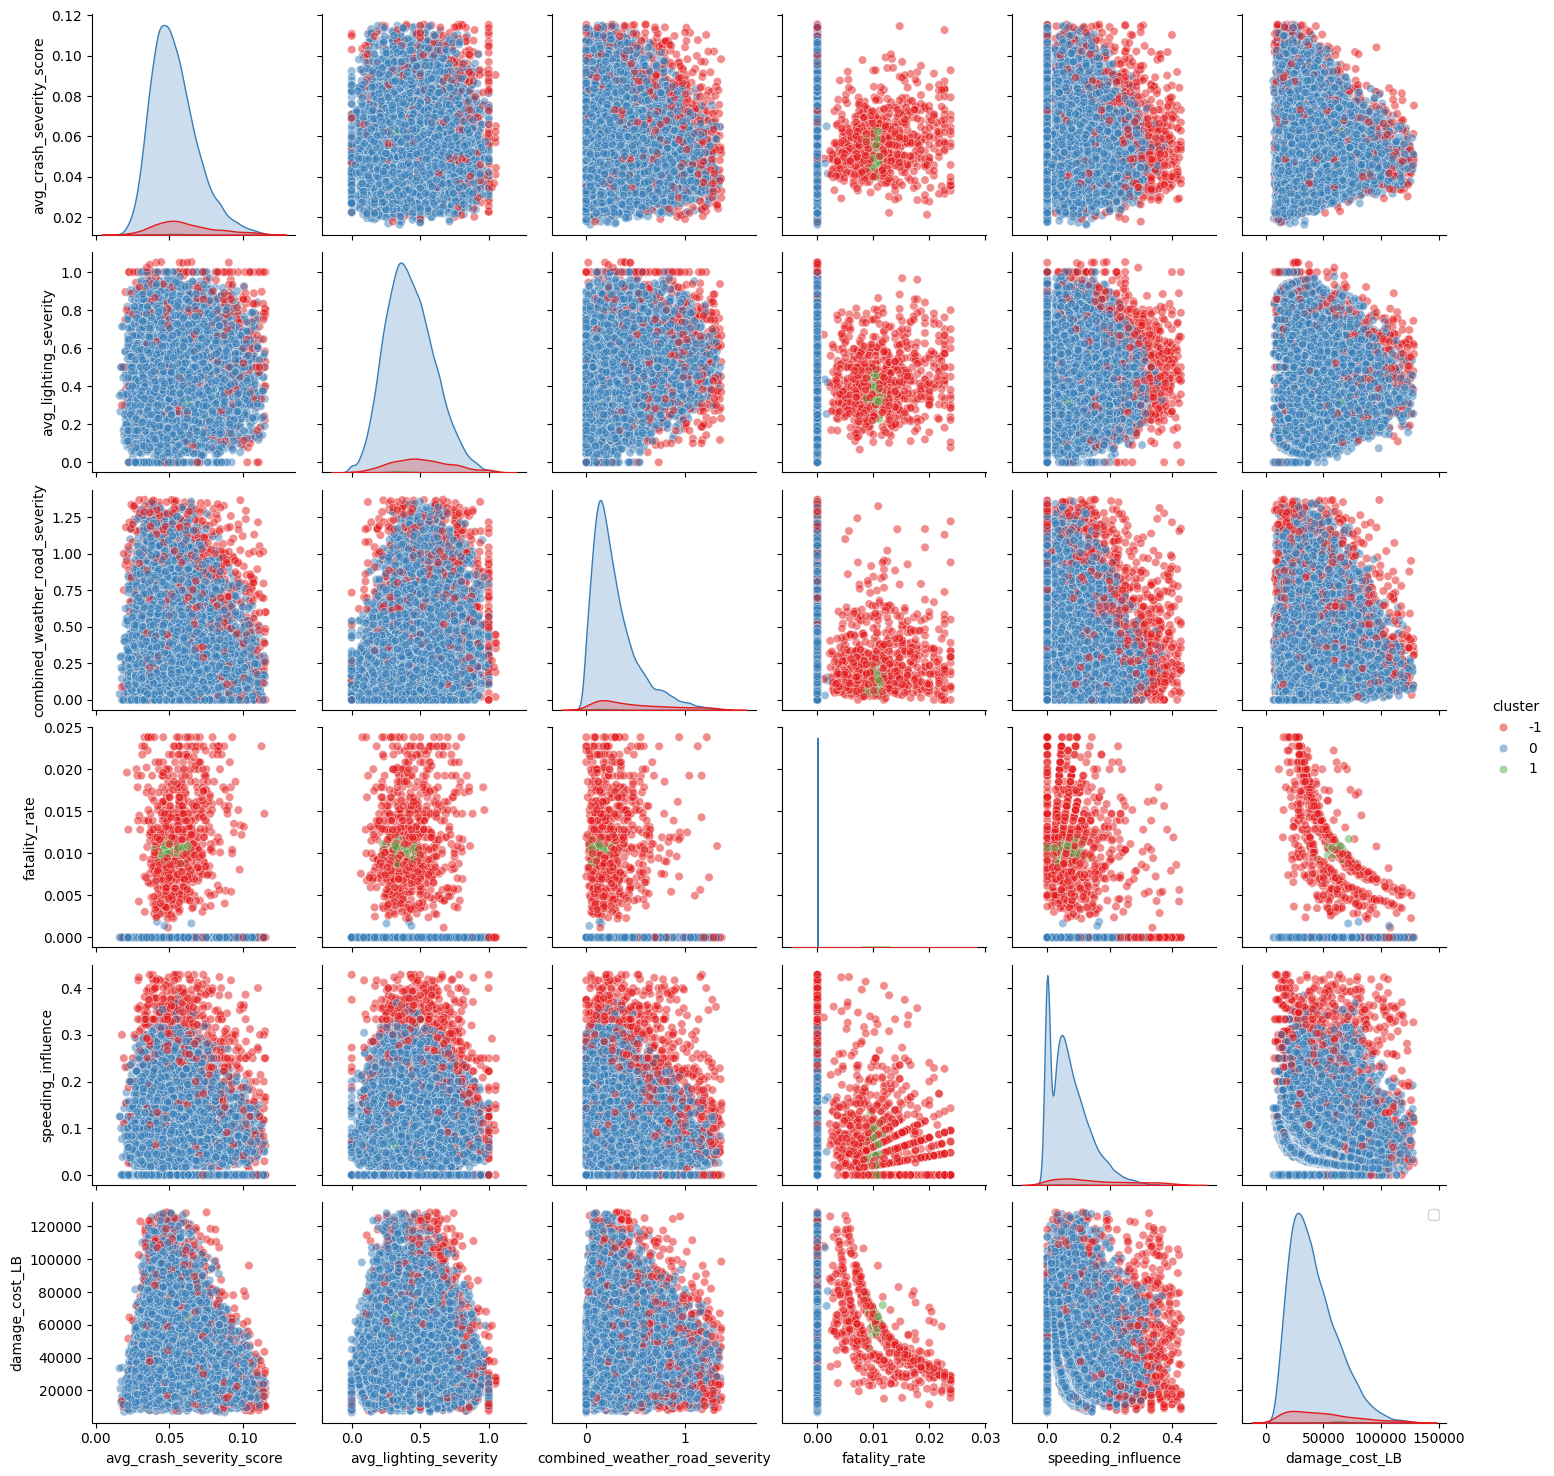

In [34]:
clusters_pairplot(df[selected_features + ['cluster']])